In [1]:
import pandas as pd
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow.keras.models import Sequential,load_model
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import Huber
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import optuna
import json
import matplotlib.ticker as ticker

In [2]:
print("TensorFlow version:", tf.__version__)
print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))
print(tf.config.list_physical_devices())

TensorFlow version: 2.10.1
Num GPUs Available: 1
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
print(tf.test.is_gpu_available())  
print(tf.config.list_physical_devices('GPU'))  
print(tf.test.gpu_device_name()) 

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
True
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
/device:GPU:0


In [4]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')
store_df = pd.read_csv('store.csv')

C:\Users\deven\AppData\Local\Temp\ipykernel_3880\3398765028.py:1: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  train_df = pd.read_csv('train.csv')


In [5]:
train_df

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1
...,...,...,...,...,...,...,...,...,...
1017204,1111,2,2013-01-01,0,0,0,0,a,1
1017205,1112,2,2013-01-01,0,0,0,0,a,1
1017206,1113,2,2013-01-01,0,0,0,0,a,1
1017207,1114,2,2013-01-01,0,0,0,0,a,1


In [6]:
test_df

,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday
0,1,1,4,2015-09-17,1.0,1,0,0
1,2,3,4,2015-09-17,1.0,1,0,0
2,3,7,4,2015-09-17,1.0,1,0,0
3,4,8,4,2015-09-17,1.0,1,0,0
4,5,9,4,2015-09-17,1.0,1,0,0
...,...,...,...,...,...,...,...,...
41083,41084,1111,6,2015-08-01,1.0,0,0,0
41084,41085,1112,6,2015-08-01,1.0,0,0,0
41085,41086,1113,6,2015-08-01,1.0,0,0,0
41086,41087,1114,6,2015-08-01,1.0,0,0,0


In [7]:
store_df

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
1110,1111,a,a,1900.0,6.0,2014.0,1,31.0,2013.0,"Jan,Apr,Jul,Oct"
1111,1112,c,c,1880.0,4.0,2006.0,0,NaN,NaN,NaN
1112,1113,a,c,9260.0,NaN,NaN,0,NaN,NaN,NaN
1113,1114,a,c,870.0,NaN,NaN,0,NaN,NaN,NaN


In [8]:
merged_df = train_df.merge(store_df, how='left', on='Store')
merged_test_df = test_df.merge(store_df, how='left', on='Store')

In [9]:
merged_test_df

,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,1,4,2015-09-17,1.0,1,0,0,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,3,4,2015-09-17,1.0,1,0,0,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
2,3,7,4,2015-09-17,1.0,1,0,0,a,c,24000.0,4.0,2013.0,0,NaN,NaN,NaN
3,4,8,4,2015-09-17,1.0,1,0,0,a,a,7520.0,10.0,2014.0,0,NaN,NaN,NaN
4,5,9,4,2015-09-17,1.0,1,0,0,a,c,2030.0,8.0,2000.0,0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41083,41084,1111,6,2015-08-01,1.0,0,0,0,a,a,1900.0,6.0,2014.0,1,31.0,2013.0,"Jan,Apr,Jul,Oct"
41084,41085,1112,6,2015-08-01,1.0,0,0,0,c,c,1880.0,4.0,2006.0,0,NaN,NaN,NaN
41085,41086,1113,6,2015-08-01,1.0,0,0,0,a,c,9260.0,NaN,NaN,0,NaN,NaN,NaN
41086,41087,1114,6,2015-08-01,1.0,0,0,0,a,c,870.0,NaN,NaN,0,NaN,NaN,NaN


In [10]:
merged_df

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1017204,1111,2,2013-01-01,0,0,0,0,a,1,a,a,1900.0,6.0,2014.0,1,31.0,2013.0,"Jan,Apr,Jul,Oct"
1017205,1112,2,2013-01-01,0,0,0,0,a,1,c,c,1880.0,4.0,2006.0,0,NaN,NaN,NaN
1017206,1113,2,2013-01-01,0,0,0,0,a,1,a,c,9260.0,NaN,NaN,0,NaN,NaN,NaN
1017207,1114,2,2013-01-01,0,0,0,0,a,1,a,c,870.0,NaN,NaN,0,NaN,NaN,NaN


In [11]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 18 columns):
 #   Column                     Non-Null Count    Dtype  
---  ------                     --------------    -----  
 0   Store                      1017209 non-null  int64  
 1   DayOfWeek                  1017209 non-null  int64  
 2   Date                       1017209 non-null  object 
 3   Sales                      1017209 non-null  int64  
 4   Customers                  1017209 non-null  int64  
 5   Open                       1017209 non-null  int64  
 6   Promo                      1017209 non-null  int64  
 7   StateHoliday               1017209 non-null  object 
 8   SchoolHoliday              1017209 non-null  int64  
 9   StoreType                  1017209 non-null  object 
 10  Assortment                 1017209 non-null  object 
 11  CompetitionDistance        1014567 non-null  float64
 12  CompetitionOpenSinceMonth  693861 non-null   float64
 13  CompetitionO

In [12]:
merged_df.isnull().sum()

Store                             0
DayOfWeek                         0
Date                              0
Sales                             0
Customers                         0
Open                              0
Promo                             0
StateHoliday                      0
SchoolHoliday                     0
StoreType                         0
Assortment                        0
CompetitionDistance            2642
CompetitionOpenSinceMonth    323348
CompetitionOpenSinceYear     323348
Promo2                            0
Promo2SinceWeek              508031
Promo2SinceYear              508031
PromoInterval                508031
dtype: int64

In [13]:
merged_df.describe()

,Store,DayOfWeek,Sales,Customers,Open,Promo,SchoolHoliday,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear
count,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.014567e+06,693861.000000,693861.000000,1.017209e+06,509178.000000,509178.000000
mean,5.584297e+02,3.998341e+00,5.773819e+03,6.331459e+02,8.301067e-01,3.815145e-01,1.786467e-01,5.430086e+03,7.222866,2008.690228,5.005638e-01,23.269093,2011.752774
std,3.219087e+02,1.997391e+00,3.849926e+03,4.644117e+02,3.755392e-01,4.857586e-01,3.830564e-01,7.715324e+03,3.211832,5.992644,4.999999e-01,14.095973,1.662870
min,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.000000e+01,1.000000,1900.000000,0.000000e+00,1.000000,2009.000000
25%,2.800000e+02,2.000000e+00,3.727000e+03,4.050000e+02,1.000000e+00,0.000000e+00,0.000000e+00,7.100000e+02,4.000000,2006.000000,0.000000e+00,13.000000,2011.000000
50%,5.580000e+02,4.000000e+00,5.744000e+03,6.090000e+02,1.000000e+00,0.000000e+00,0.000000e+00,2.330000e+03,8.000000,2010.000000,1.000000e+00,22.000000,2012.000000
75%,8.380000e+02,6.000000e+00,7.856000e+03,8.370000e+02,1.000000e+00,1.000000e+00,0.000000e+00,6.890000e+03,10.000000,2013.000000,1.000000e+00,37.000000,2013.000000
max,1.115000e+03,7.000000e+00,4.155100e+04,7.388000e+03,1.000000e+00,1.000000e+00,1.000000e+00,7.586000e+04,12.000000,2015.000000,1.000000e+00,50.000000,2015.000000


In [14]:
merged_df.Date = pd.to_datetime(merged_df.Date)
merged_test_df.Date = pd.to_datetime(merged_test_df.Date)

In [15]:
merged_df["Year"] = merged_df["Date"].dt.year
merged_df["Month"] = merged_df["Date"].dt.month
merged_df["Day"] = merged_df["Date"].dt.day
merged_df["DayOfWeek"] = merged_df["Date"].dt.dayofweek
merged_df["WeekOfYear"] = merged_df["Date"].dt.isocalendar().week
merged_df["IsWeekend"] = (merged_df["Date"].dt.dayofweek >= 5).astype(int)

merged_test_df["Year"] = merged_test_df["Date"].dt.year
merged_test_df["Month"] = merged_test_df["Date"].dt.month
merged_test_df["Day"] = merged_test_df["Date"].dt.day
merged_test_df["DayOfWeek"] = merged_test_df["Date"].dt.dayofweek
merged_test_df["WeekOfYear"] = merged_test_df["Date"].dt.isocalendar().week
merged_test_df["IsWeekend"] = (merged_test_df["Date"].dt.dayofweek >= 5).astype(int)

<Axes: xlabel='Sales', ylabel='Count'>

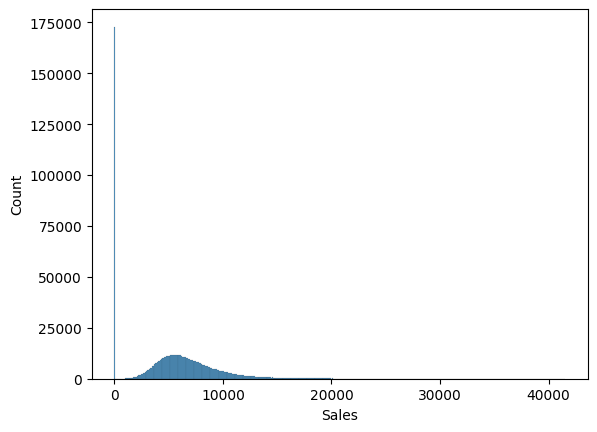

In [16]:
sns.histplot(merged_df.Sales)

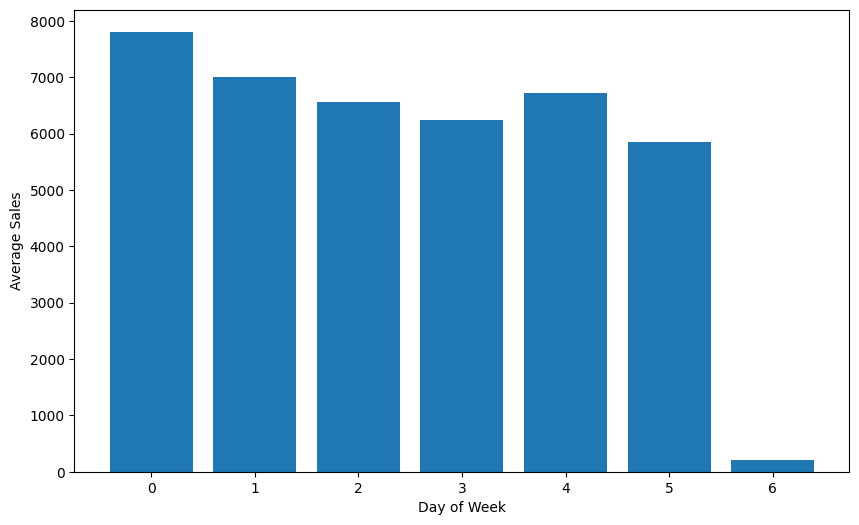

In [17]:
plt.figure(figsize=(10, 6))
plt.bar(merged_df.groupby('DayOfWeek').Sales.mean().index, merged_df.groupby('DayOfWeek').Sales.mean().values)
plt.xlabel('Day of Week')
plt.ylabel('Average Sales')
plt.show()

In [18]:
merged_df['Open'].value_counts()

Open
1    844392
0    172817
Name: count, dtype: int64

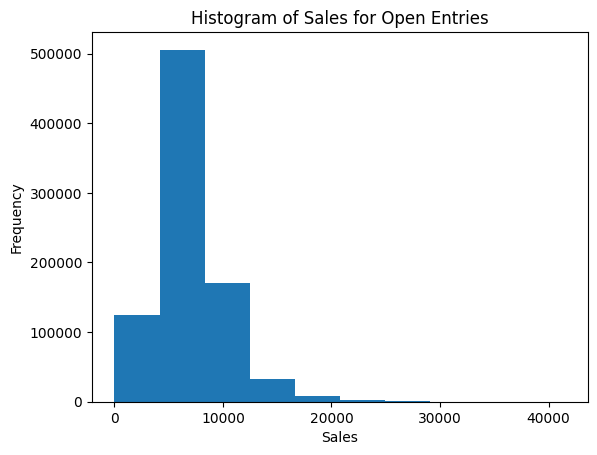

In [19]:
plt.hist(merged_df[merged_df['Open'] == True]['Sales'])  
plt.xlabel('Sales')
plt.ylabel('Frequency')
plt.title('Histogram of Sales for Open Entries')
plt.show()

C:\Users\deven\AppData\Local\Temp\ipykernel_3880\2236914780.py:2: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(merged_df.select_dtypes(include='number').values, labels=merged_df.select_dtypes(include='number').columns)
d:\Main_Python\.venv310\lib\site-packages\matplotlib\cbook.py:1267: RuntimeWarning: invalid value encountered in less_equal
  wiskhi = x[x <= hival]
d:\Main_Python\.venv310\lib\site-packages\matplotlib\cbook.py:1274: RuntimeWarning: invalid value encountered in greater_equal
  wisklo = x[x >= loval]
d:\Main_Python\.venv310\lib\site-packages\matplotlib\cbook.py:1282: RuntimeWarning: invalid value encountered in less
  x[x < stats['whislo']],
d:\Main_Python\.venv310\lib\site-packages\matplotlib\cbook.py:1283: RuntimeWarning: invalid value encountered in greater
  x[x > stats['whishi']],


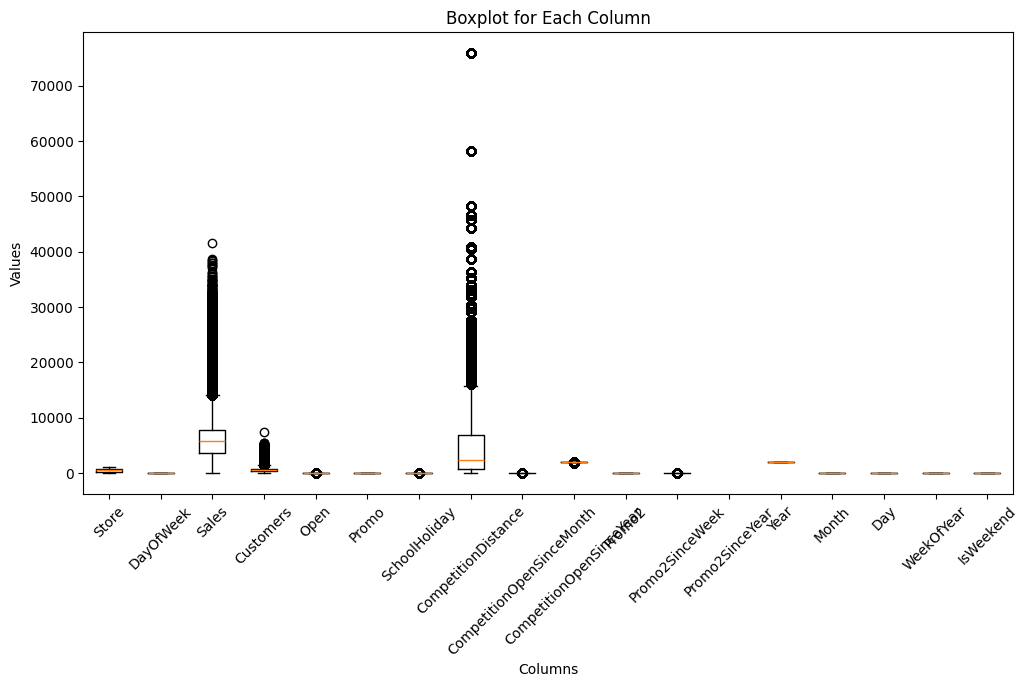

In [20]:
plt.figure(figsize=(12, 6))
plt.boxplot(merged_df.select_dtypes(include='number').values, labels=merged_df.select_dtypes(include='number').columns)
plt.xticks(rotation=45) 
plt.xlabel('Columns')
plt.ylabel('Values')
plt.title('Boxplot for Each Column')
plt.show()

In [21]:
Q1 = merged_df['Sales'].quantile(0.25)  
Q3 = merged_df['Sales'].quantile(0.75)  
IQR = Q3 - Q1  

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

merged_df = merged_df[(merged_df['Sales'] >= lower_bound) & (merged_df['Sales'] <= upper_bound)]

C:\Users\deven\AppData\Local\Temp\ipykernel_3880\2236914780.py:2: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(merged_df.select_dtypes(include='number').values, labels=merged_df.select_dtypes(include='number').columns)
d:\Main_Python\.venv310\lib\site-packages\matplotlib\cbook.py:1267: RuntimeWarning: invalid value encountered in less_equal
  wiskhi = x[x <= hival]
d:\Main_Python\.venv310\lib\site-packages\matplotlib\cbook.py:1274: RuntimeWarning: invalid value encountered in greater_equal
  wisklo = x[x >= loval]
d:\Main_Python\.venv310\lib\site-packages\matplotlib\cbook.py:1282: RuntimeWarning: invalid value encountered in less
  x[x < stats['whislo']],
d:\Main_Python\.venv310\lib\site-packages\matplotlib\cbook.py:1283: RuntimeWarning: invalid value encountered in greater
  x[x > stats['whishi']],


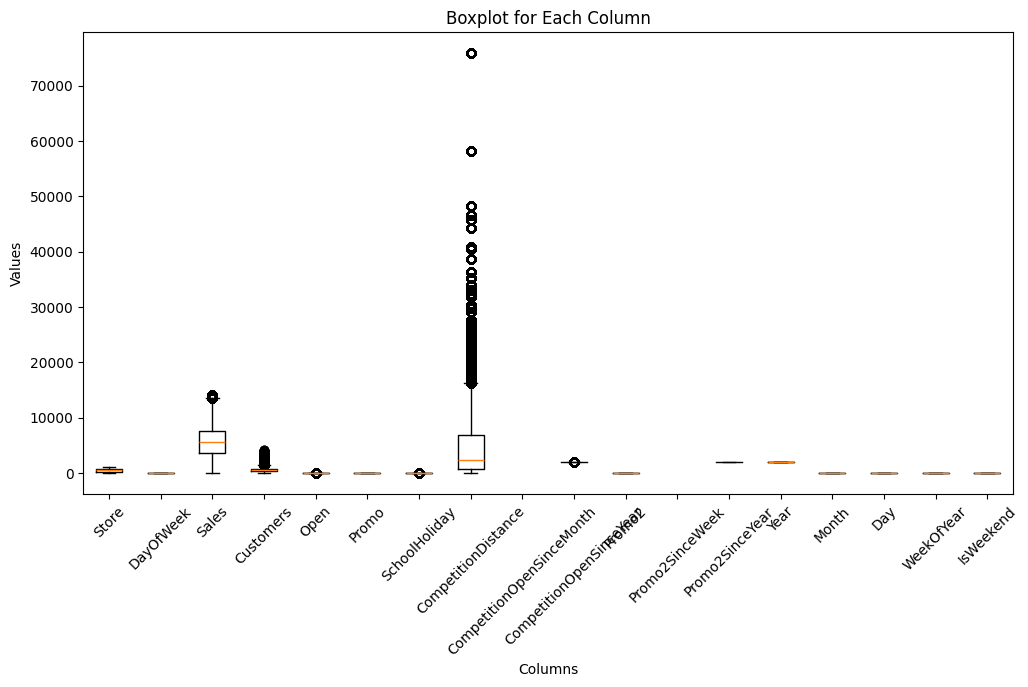

In [22]:
plt.figure(figsize=(12, 6))
plt.boxplot(merged_df.select_dtypes(include='number').values, labels=merged_df.select_dtypes(include='number').columns)
plt.xticks(rotation=45) 
plt.xlabel('Columns')
plt.ylabel('Values')
plt.title('Boxplot for Each Column')
plt.show()

In [23]:
Q1 = merged_df['Customers'].quantile(0.25)  
Q3 = merged_df['Customers'].quantile(0.75)  
IQR = Q3 - Q1  

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

merged_df = merged_df[(merged_df['Customers'] >= lower_bound) & (merged_df['Customers'] <= upper_bound)]

C:\Users\deven\AppData\Local\Temp\ipykernel_3880\2236914780.py:2: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(merged_df.select_dtypes(include='number').values, labels=merged_df.select_dtypes(include='number').columns)
d:\Main_Python\.venv310\lib\site-packages\matplotlib\cbook.py:1267: RuntimeWarning: invalid value encountered in less_equal
  wiskhi = x[x <= hival]
d:\Main_Python\.venv310\lib\site-packages\matplotlib\cbook.py:1274: RuntimeWarning: invalid value encountered in greater_equal
  wisklo = x[x >= loval]
d:\Main_Python\.venv310\lib\site-packages\matplotlib\cbook.py:1282: RuntimeWarning: invalid value encountered in less
  x[x < stats['whislo']],
d:\Main_Python\.venv310\lib\site-packages\matplotlib\cbook.py:1283: RuntimeWarning: invalid value encountered in greater
  x[x > stats['whishi']],


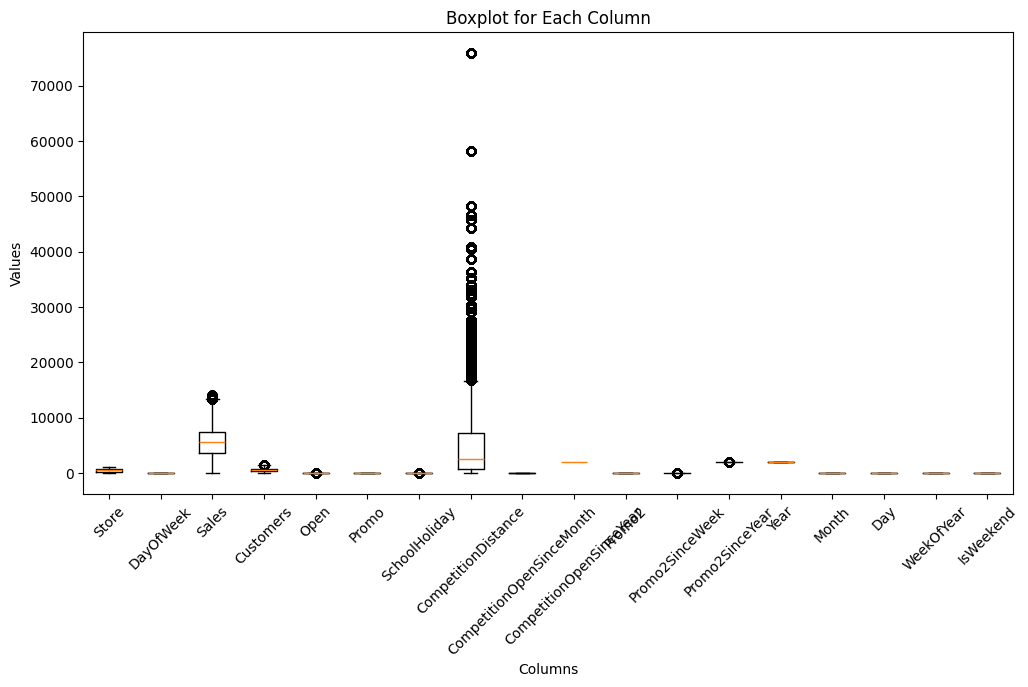

In [24]:
plt.figure(figsize=(12, 6))
plt.boxplot(merged_df.select_dtypes(include='number').values, labels=merged_df.select_dtypes(include='number').columns)
plt.xticks(rotation=45) 
plt.xlabel('Columns')
plt.ylabel('Values')
plt.title('Boxplot for Each Column')
plt.show()

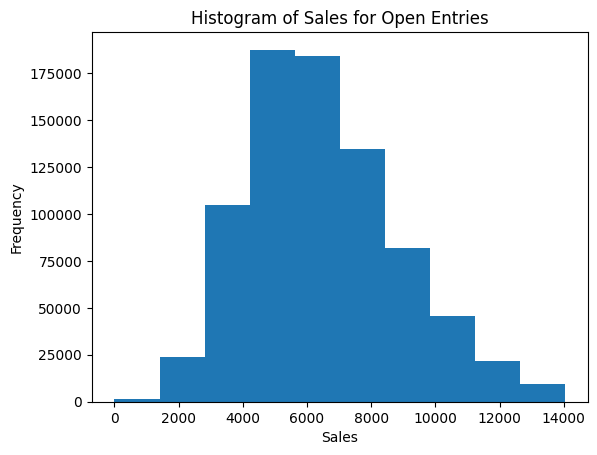

In [25]:
plt.hist(merged_df[merged_df['Open'] == True]['Sales'])  
plt.xlabel('Sales')
plt.ylabel('Frequency')
plt.title('Histogram of Sales for Open Entries')
plt.show()

In [26]:
merged_df['Date']

0         2015-07-31
1         2015-07-31
2         2015-07-31
4         2015-07-31
5         2015-07-31
             ...    
1017204   2013-01-01
1017205   2013-01-01
1017206   2013-01-01
1017207   2013-01-01
1017208   2013-01-01
Name: Date, Length: 967874, dtype: datetime64[ns]

In [27]:
def split_date(df):
  df['Date'] = pd.to_datetime(df['Date'])
  df['Year'] = df['Date'].dt.year
  df['Month'] = df['Date'].dt.month
  df['Day'] = df['Date'].dt.day
  df['WeekOfYear'] = df.Date.dt.isocalendar().week

In [28]:
split_date(merged_df)
split_date(merged_test_df)

In [29]:
merged_df

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,...,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,Year,Month,Day,WeekOfYear,IsWeekend
0,1,4,2015-07-31,5263,555,1,1,0,1,c,...,2008.0,0,NaN,NaN,NaN,2015,7,31,31,0
1,2,4,2015-07-31,6064,625,1,1,0,1,a,...,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct",2015,7,31,31,0
2,3,4,2015-07-31,8314,821,1,1,0,1,a,...,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct",2015,7,31,31,0
4,5,4,2015-07-31,4822,559,1,1,0,1,a,...,2015.0,0,NaN,NaN,NaN,2015,7,31,31,0
5,6,4,2015-07-31,5651,589,1,1,0,1,a,...,2013.0,0,NaN,NaN,NaN,2015,7,31,31,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1017204,1111,1,2013-01-01,0,0,0,0,a,1,a,...,2014.0,1,31.0,2013.0,"Jan,Apr,Jul,Oct",2013,1,1,1,0
1017205,1112,1,2013-01-01,0,0,0,0,a,1,c,...,2006.0,0,NaN,NaN,NaN,2013,1,1,1,0
1017206,1113,1,2013-01-01,0,0,0,0,a,1,a,...,NaN,0,NaN,NaN,NaN,2013,1,1,1,0
1017207,1114,1,2013-01-01,0,0,0,0,a,1,a,...,NaN,0,NaN,NaN,NaN,2013,1,1,1,0


In [30]:
month_map = {
    "Jan": 1, "Feb": 2, "Mar": 3, "Apr": 4, "May": 5, "Jun": 6,
    "Jul": 7, "Aug": 8, "Sept": 9, "Oct": 10, "Nov": 11, "Dec": 12
}

def convert_promo_interval(promo_str):
    if pd.isna(promo_str):  
        return ""
    return ",".join(str(month_map[m]) for m in promo_str.split(","))

merged_df['PromoInterval_converted'] = merged_df['PromoInterval'].apply(convert_promo_interval)

In [31]:
merged_df

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,...,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,Year,Month,Day,WeekOfYear,IsWeekend,PromoInterval_converted
0,1,4,2015-07-31,5263,555,1,1,0,1,c,...,0,NaN,NaN,NaN,2015,7,31,31,0,
1,2,4,2015-07-31,6064,625,1,1,0,1,a,...,1,13.0,2010.0,"Jan,Apr,Jul,Oct",2015,7,31,31,0,"1,4,7,10"
2,3,4,2015-07-31,8314,821,1,1,0,1,a,...,1,14.0,2011.0,"Jan,Apr,Jul,Oct",2015,7,31,31,0,"1,4,7,10"
4,5,4,2015-07-31,4822,559,1,1,0,1,a,...,0,NaN,NaN,NaN,2015,7,31,31,0,
5,6,4,2015-07-31,5651,589,1,1,0,1,a,...,0,NaN,NaN,NaN,2015,7,31,31,0,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1017204,1111,1,2013-01-01,0,0,0,0,a,1,a,...,1,31.0,2013.0,"Jan,Apr,Jul,Oct",2013,1,1,1,0,"1,4,7,10"
1017205,1112,1,2013-01-01,0,0,0,0,a,1,c,...,0,NaN,NaN,NaN,2013,1,1,1,0,
1017206,1113,1,2013-01-01,0,0,0,0,a,1,a,...,0,NaN,NaN,NaN,2013,1,1,1,0,
1017207,1114,1,2013-01-01,0,0,0,0,a,1,a,...,0,NaN,NaN,NaN,2013,1,1,1,0,


In [32]:
def check_promo_month(row):
    if pd.isna(row['PromoInterval_converted']) or row['PromoInterval_converted'] == "":
        return 0

    promo_months = list(map(int, row['PromoInterval_converted'].split(',')))
    return 1 if row['Month'] in promo_months else 0

merged_df['IsPromoMonth'] = merged_df.apply(check_promo_month, axis=1)

In [33]:
new_df = merged_df.copy()

In [34]:
new_df

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,...,Promo2SinceWeek,Promo2SinceYear,PromoInterval,Year,Month,Day,WeekOfYear,IsWeekend,PromoInterval_converted,IsPromoMonth
0,1,4,2015-07-31,5263,555,1,1,0,1,c,...,NaN,NaN,NaN,2015,7,31,31,0,,0
1,2,4,2015-07-31,6064,625,1,1,0,1,a,...,13.0,2010.0,"Jan,Apr,Jul,Oct",2015,7,31,31,0,"1,4,7,10",1
2,3,4,2015-07-31,8314,821,1,1,0,1,a,...,14.0,2011.0,"Jan,Apr,Jul,Oct",2015,7,31,31,0,"1,4,7,10",1
4,5,4,2015-07-31,4822,559,1,1,0,1,a,...,NaN,NaN,NaN,2015,7,31,31,0,,0
5,6,4,2015-07-31,5651,589,1,1,0,1,a,...,NaN,NaN,NaN,2015,7,31,31,0,,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1017204,1111,1,2013-01-01,0,0,0,0,a,1,a,...,31.0,2013.0,"Jan,Apr,Jul,Oct",2013,1,1,1,0,"1,4,7,10",1
1017205,1112,1,2013-01-01,0,0,0,0,a,1,c,...,NaN,NaN,NaN,2013,1,1,1,0,,0
1017206,1113,1,2013-01-01,0,0,0,0,a,1,a,...,NaN,NaN,NaN,2013,1,1,1,0,,0
1017207,1114,1,2013-01-01,0,0,0,0,a,1,a,...,NaN,NaN,NaN,2013,1,1,1,0,,0


In [35]:
new_df = new_df.drop(['PromoInterval', 'PromoInterval_converted','CompetitionDistance','CompetitionOpenSinceMonth','CompetitionOpenSinceYear','Promo2SinceWeek','Promo2SinceYear'], axis=1)
new_df

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,Promo2,Year,Month,Day,WeekOfYear,IsWeekend,IsPromoMonth
0,1,4,2015-07-31,5263,555,1,1,0,1,c,a,0,2015,7,31,31,0,0
1,2,4,2015-07-31,6064,625,1,1,0,1,a,a,1,2015,7,31,31,0,1
2,3,4,2015-07-31,8314,821,1,1,0,1,a,a,1,2015,7,31,31,0,1
4,5,4,2015-07-31,4822,559,1,1,0,1,a,a,0,2015,7,31,31,0,0
5,6,4,2015-07-31,5651,589,1,1,0,1,a,a,0,2015,7,31,31,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1017204,1111,1,2013-01-01,0,0,0,0,a,1,a,a,1,2013,1,1,1,0,1
1017205,1112,1,2013-01-01,0,0,0,0,a,1,c,c,0,2013,1,1,1,0,0
1017206,1113,1,2013-01-01,0,0,0,0,a,1,a,c,0,2013,1,1,1,0,0
1017207,1114,1,2013-01-01,0,0,0,0,a,1,a,c,0,2013,1,1,1,0,0


In [36]:
new_df.isnull().sum()

Store            0
DayOfWeek        0
Date             0
Sales            0
Customers        0
Open             0
Promo            0
StateHoliday     0
SchoolHoliday    0
StoreType        0
Assortment       0
Promo2           0
Year             0
Month            0
Day              0
WeekOfYear       0
IsWeekend        0
IsPromoMonth     0
dtype: int64

In [37]:
encoder = LabelEncoder()
new_df['StoreType'] = encoder.fit_transform(new_df['StoreType'])

In [38]:
new_df['Assortment'] = encoder.fit_transform(new_df['Assortment'])

In [39]:
new_df

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,Promo2,Year,Month,Day,WeekOfYear,IsWeekend,IsPromoMonth
0,1,4,2015-07-31,5263,555,1,1,0,1,2,0,0,2015,7,31,31,0,0
1,2,4,2015-07-31,6064,625,1,1,0,1,0,0,1,2015,7,31,31,0,1
2,3,4,2015-07-31,8314,821,1,1,0,1,0,0,1,2015,7,31,31,0,1
4,5,4,2015-07-31,4822,559,1,1,0,1,0,0,0,2015,7,31,31,0,0
5,6,4,2015-07-31,5651,589,1,1,0,1,0,0,0,2015,7,31,31,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1017204,1111,1,2013-01-01,0,0,0,0,a,1,0,0,1,2013,1,1,1,0,1
1017205,1112,1,2013-01-01,0,0,0,0,a,1,2,2,0,2013,1,1,1,0,0
1017206,1113,1,2013-01-01,0,0,0,0,a,1,0,2,0,2013,1,1,1,0,0
1017207,1114,1,2013-01-01,0,0,0,0,a,1,0,2,0,2013,1,1,1,0,0


In [40]:
new_df['StateHoliday'] = new_df['StateHoliday'].astype(str)
new_df['StateHoliday'] = encoder.fit_transform(new_df['StateHoliday'])

In [41]:
new_df

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,Promo2,Year,Month,Day,WeekOfYear,IsWeekend,IsPromoMonth
0,1,4,2015-07-31,5263,555,1,1,0,1,2,0,0,2015,7,31,31,0,0
1,2,4,2015-07-31,6064,625,1,1,0,1,0,0,1,2015,7,31,31,0,1
2,3,4,2015-07-31,8314,821,1,1,0,1,0,0,1,2015,7,31,31,0,1
4,5,4,2015-07-31,4822,559,1,1,0,1,0,0,0,2015,7,31,31,0,0
5,6,4,2015-07-31,5651,589,1,1,0,1,0,0,0,2015,7,31,31,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1017204,1111,1,2013-01-01,0,0,0,0,1,1,0,0,1,2013,1,1,1,0,1
1017205,1112,1,2013-01-01,0,0,0,0,1,1,2,2,0,2013,1,1,1,0,0
1017206,1113,1,2013-01-01,0,0,0,0,1,1,0,2,0,2013,1,1,1,0,0
1017207,1114,1,2013-01-01,0,0,0,0,1,1,0,2,0,2013,1,1,1,0,0


In [42]:
new_df.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment', 'Promo2',
       'Year', 'Month', 'Day', 'WeekOfYear', 'IsWeekend', 'IsPromoMonth'],
      dtype='object')

### Model Training

In [43]:
df = new_df.copy()
df = df.sort_values(by=["Date"])

df["Year"] = df["Date"].dt.year
df["Month"] = df["Date"].dt.month
df["Day"] = df["Date"].dt.day
df["DayOfWeek"] = df["Date"].dt.dayofweek
df["WeekOfYear"] = df["Date"].dt.isocalendar().week
df["IsWeekend"] = (df["Date"].dt.dayofweek >= 5).astype(int)

features = df.drop(['Sales', 'Date'], axis=1).columns.tolist()
target = "Sales"

In [44]:
scaler = MinMaxScaler()
df[features] = scaler.fit_transform(df[features])

target_scaler = MinMaxScaler()
df[target] = target_scaler.fit_transform(df[[target]]) 

def create_sequences(data, target_col, seq_length=30):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data.iloc[i : i + seq_length][features].values)
        y.append(data.iloc[i + seq_length][target_col])
    return np.array(X), np.array(y)

X, y = create_sequences(df, target)

In [45]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

print("Input Shape:", X_train.shape)  

Input Shape: (774275, 30, 16)


In [46]:
X_train = tf.convert_to_tensor(X_train, dtype=tf.float32)
y_train = tf.convert_to_tensor(y_train, dtype=tf.float32)
X_test = tf.convert_to_tensor(X_test, dtype=tf.float32)
y_test = tf.convert_to_tensor(y_test, dtype=tf.float32)

In [76]:
model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    LSTM(32, return_sequences=False),
    Dense(32, activation='relu', kernel_regularizer='l2'),
    Dense(16, activation='relu', kernel_regularizer='l2'),
    Dense(1)
])


In [77]:
model.compile(optimizer='rmsprop',
              loss=tf.keras.losses.Huber(delta=50.0),  
              metrics=["mae"])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 30, 64)            20736     
                                                                 
 lstm_3 (LSTM)               (None, 32)                12416     
                                                                 
 dense_3 (Dense)             (None, 32)                1056      
                                                                 
 dense_4 (Dense)             (None, 16)                528       
                                                                 
 dense_5 (Dense)             (None, 1)                 17        
                                                                 
Total params: 34,753
Trainable params: 34,753
Non-trainable params: 0
_________________________________________________________________


In [78]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=10,  
    restore_best_weights=True,
    min_delta=0.001 
)

with tf.device('/device:GPU:0'):
    history = model.fit(
        X_train, y_train,
        epochs=100,  
        batch_size=64,   
        validation_data=(X_test, y_test),
        callbacks=[early_stopping],
        verbose=2  
    )

Epoch 1/100
12011/12011 - 209s - loss: 0.0143 - mae: 0.1045 - val_loss: 0.0102 - val_mae: 0.1043 - 209s/epoch - 17ms/step
Epoch 2/100
12011/12011 - 192s - loss: 0.0100 - mae: 0.1012 - val_loss: 0.0120 - val_mae: 0.1069 - 192s/epoch - 16ms/step
Epoch 3/100
12011/12011 - 192s - loss: 0.0094 - mae: 0.0977 - val_loss: 0.0095 - val_mae: 0.1004 - 192s/epoch - 16ms/step
Epoch 4/100
12011/12011 - 190s - loss: 0.0084 - mae: 0.0902 - val_loss: 0.0080 - val_mae: 0.0907 - 190s/epoch - 16ms/step
Epoch 5/100
12011/12011 - 218s - loss: 0.0075 - mae: 0.0837 - val_loss: 0.0076 - val_mae: 0.0862 - 218s/epoch - 18ms/step
Epoch 6/100
12011/12011 - 225s - loss: 0.0070 - mae: 0.0797 - val_loss: 0.0083 - val_mae: 0.0961 - 225s/epoch - 19ms/step
Epoch 7/100
12011/12011 - 223s - loss: 0.0067 - mae: 0.0772 - val_loss: 0.0096 - val_mae: 0.0978 - 223s/epoch - 19ms/step
Epoch 8/100
12011/12011 - 197s - loss: 0.0065 - mae: 0.0753 - val_loss: 0.0090 - val_mae: 0.0921 - 197s/epoch - 16ms/step
Epoch 9/100
12011/12011 

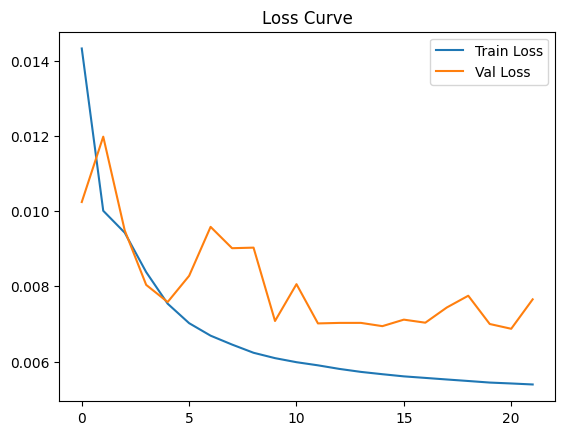

In [79]:
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title("Loss Curve")
plt.show()


In [80]:
for var in model.trainable_variables:
    print(f"Variable: {var.name}, Device: {var.device}")

Variable: lstm_2/lstm_cell_2/kernel:0, Device: /job:localhost/replica:0/task:0/device:GPU:0
Variable: lstm_2/lstm_cell_2/recurrent_kernel:0, Device: /job:localhost/replica:0/task:0/device:GPU:0
Variable: lstm_2/lstm_cell_2/bias:0, Device: /job:localhost/replica:0/task:0/device:GPU:0
Variable: lstm_3/lstm_cell_3/kernel:0, Device: /job:localhost/replica:0/task:0/device:GPU:0
Variable: lstm_3/lstm_cell_3/recurrent_kernel:0, Device: /job:localhost/replica:0/task:0/device:GPU:0
Variable: lstm_3/lstm_cell_3/bias:0, Device: /job:localhost/replica:0/task:0/device:GPU:0
Variable: dense_3/kernel:0, Device: /job:localhost/replica:0/task:0/device:GPU:0
Variable: dense_3/bias:0, Device: /job:localhost/replica:0/task:0/device:GPU:0
Variable: dense_4/kernel:0, Device: /job:localhost/replica:0/task:0/device:GPU:0
Variable: dense_4/bias:0, Device: /job:localhost/replica:0/task:0/device:GPU:0
Variable: dense_5/kernel:0, Device: /job:localhost/replica:0/task:0/device:GPU:0
Variable: dense_5/bias:0, Devic

In [81]:
model.save("model.h5")

In [82]:
model = load_model("model.h5")
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 30, 64)            20736     
                                                                 
 lstm_3 (LSTM)               (None, 32)                12416     
                                                                 
 dense_3 (Dense)             (None, 32)                1056      
                                                                 
 dense_4 (Dense)             (None, 16)                528       
                                                                 
 dense_5 (Dense)             (None, 1)                 17        
                                                                 
Total params: 34,753
Trainable params: 34,753
Non-trainable params: 0
_________________________________________________________________


In [83]:
loss, mae = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss:.4f}, Test MAE: {mae:.4f}")


predictions = model.predict(X_test)

y_test_original = target_scaler.inverse_transform(np.array(y_test).reshape(-1, 1))
predictions_original = target_scaler.inverse_transform(predictions)

6006/6006 [==============================] - 41s 7ms/step - loss: 0.0070 - mae: 0.0782
Test Loss: 0.0070, Test MAE: 0.0782
6006/6006 [==============================] - 33s 5ms/step


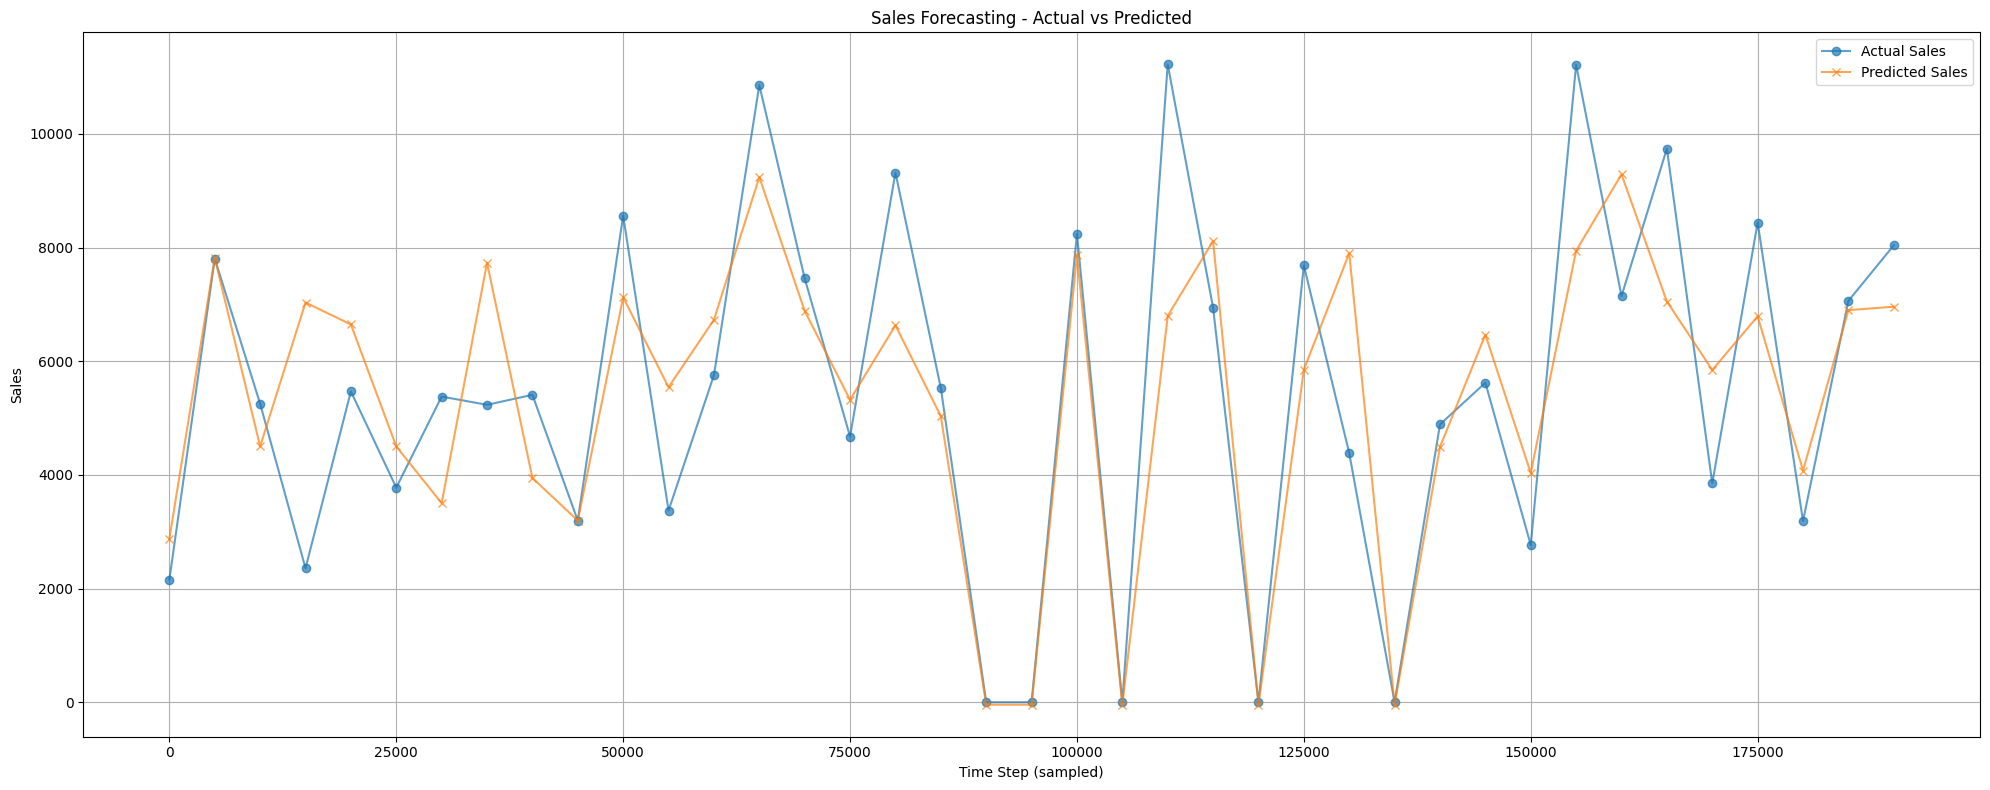

In [90]:
step = 5000  
indices = np.arange(0, len(y_test_original), step)

plt.figure(figsize=(20, 8))
plt.plot(indices, y_test_original[indices], label="Actual Sales", marker='o', linestyle='-', alpha=0.7)
plt.plot(indices, predictions_original[indices], label="Predicted Sales", marker='x', linestyle='-', alpha=0.7)
plt.legend()
plt.title("Sales Forecasting - Actual vs Predicted")
plt.xlabel("Time Step (sampled)")
plt.ylabel("Sales")
plt.grid(True)
plt.tight_layout()
plt.show()

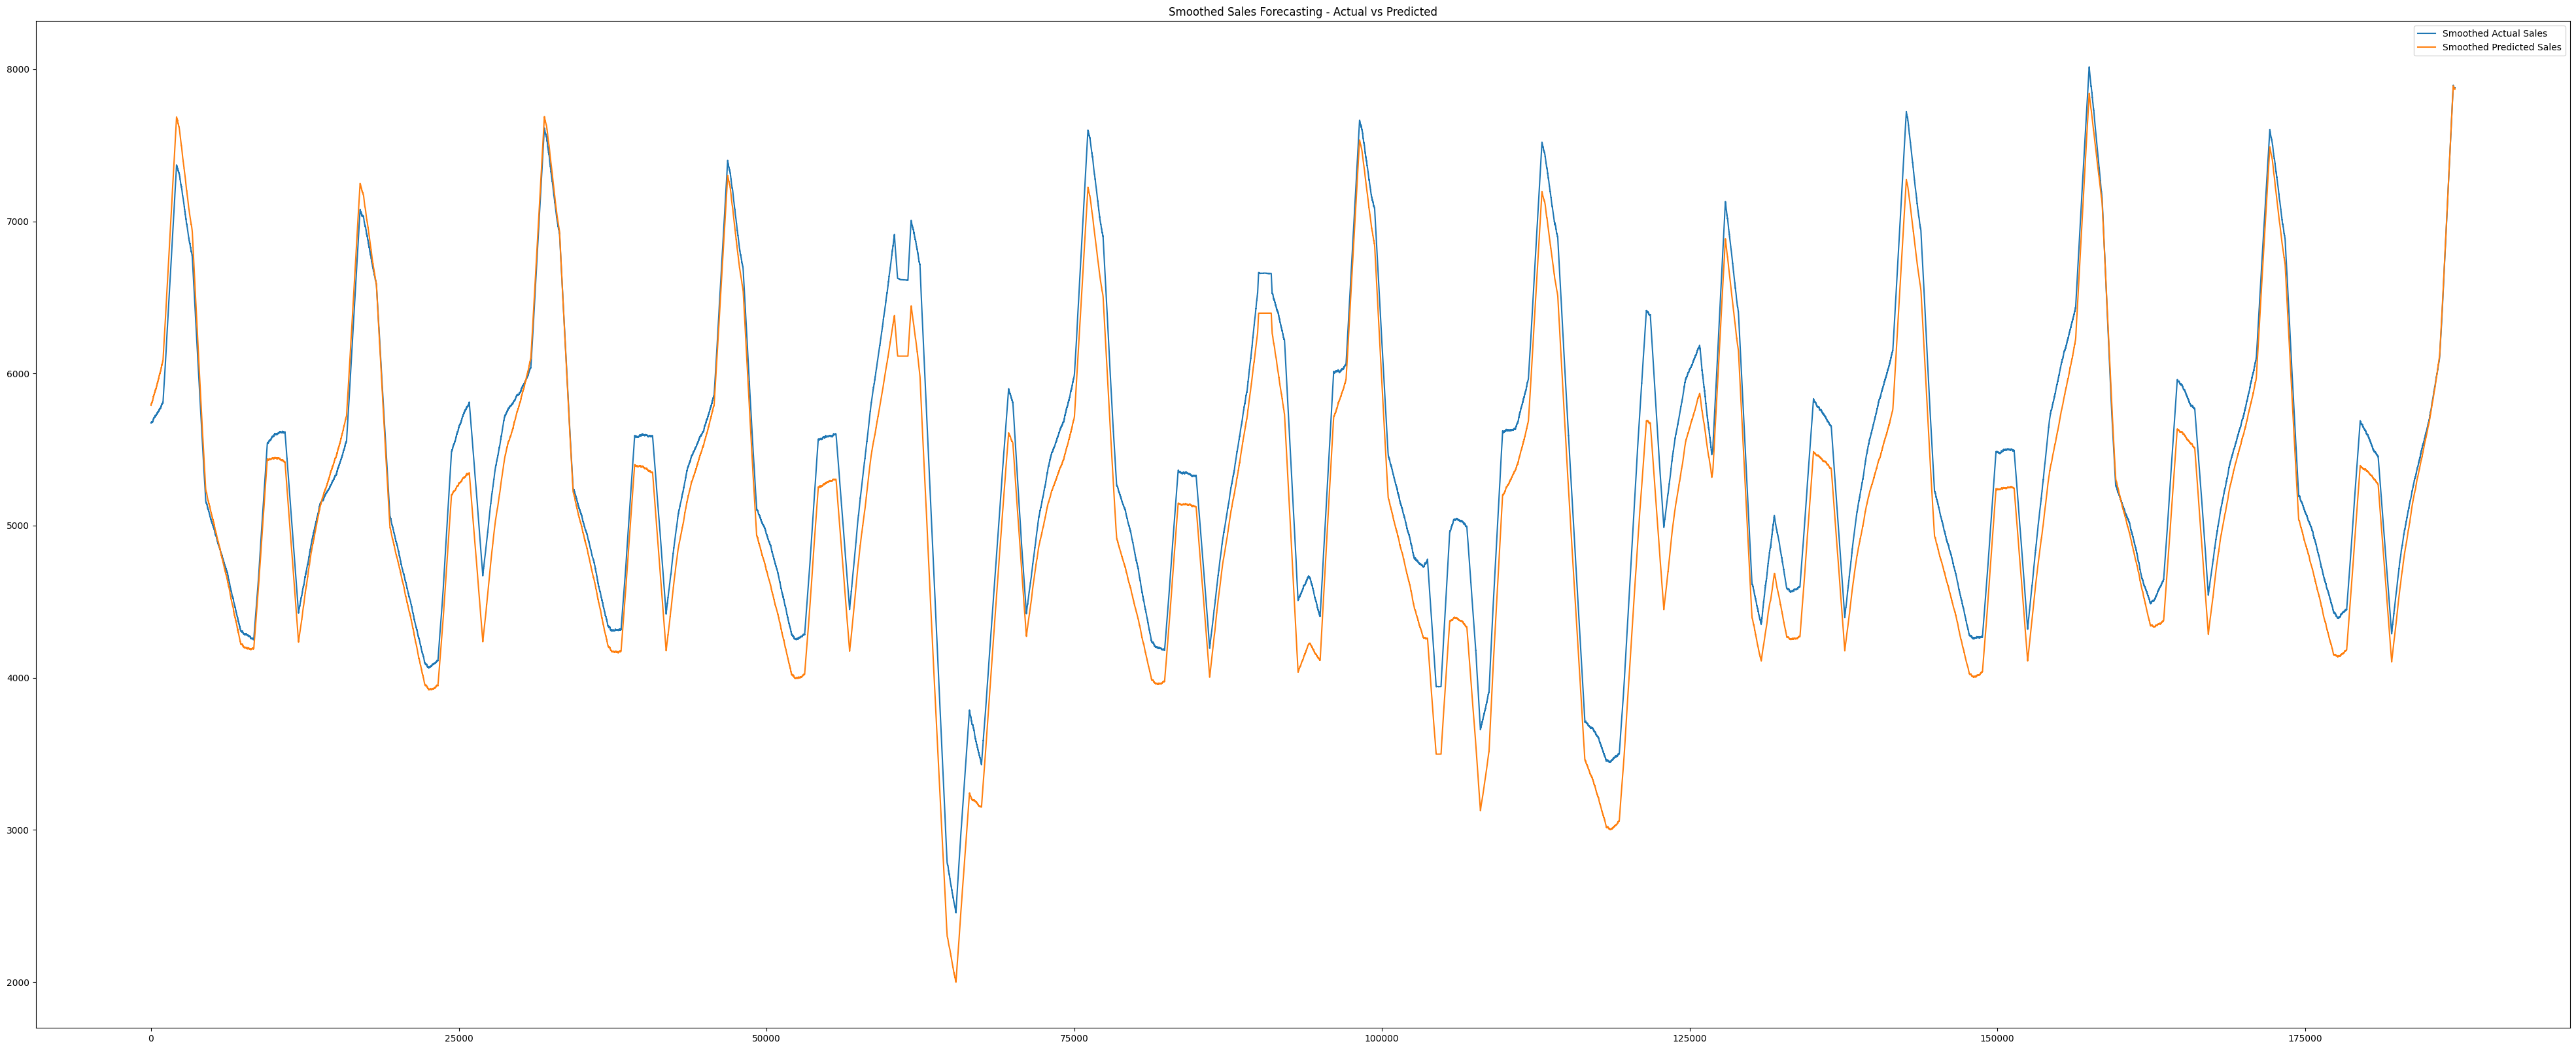

In [92]:
window = 5000  
y_test_smooth = np.convolve(y_test_original.flatten(), np.ones(window)/window, mode='valid')
predictions_smooth = np.convolve(predictions_original.flatten(), np.ones(window)/window, mode='valid')

plt.figure(figsize=(50, 20))
plt.plot(y_test_smooth, label="Smoothed Actual Sales", linestyle="-")
plt.plot(predictions_smooth, label="Smoothed Predicted Sales", linestyle="-")
plt.legend()
plt.title("Smoothed Sales Forecasting - Actual vs Predicted")
plt.show()

In [93]:
def evaluate_model(y_true, y_pred, step=100):
    indices = np.arange(0, len(y_true), step)
    y_true_sampled = y_true[indices]
    y_pred_sampled = y_pred[indices]
    
    rmse = mean_squared_error(y_true_sampled, y_pred_sampled) ** 0.5 
    mae = mean_absolute_error(y_true_sampled, y_pred_sampled)
    r2 = r2_score(y_true_sampled, y_pred_sampled)
    
    print(f'RMSE: {rmse:.2f}')
    print(f'MAE: {mae:.2f}')
    print(f'R² Score: {r2:.4f}')

evaluate_model(y_test_original, predictions_original, step=100)

RMSE: 1587.56
MAE: 1073.15
R² Score: 0.7714


In [94]:
def objective(trial):
    lstm_units = trial.suggest_categorical("lstm_units", [64, 128, 256])
    dropout_rate = trial.suggest_float("dropout_rate", 0.1, 0.5)
    dense_units_1 = trial.suggest_categorical("dense_units_1", [16, 32, 64])
    dense_units_2 = trial.suggest_categorical("dense_units_2", [8, 16, 32])
    learning_rate = trial.suggest_float("learning_rate", 1e-4, 1e-2, log=True)
    batch_size = trial.suggest_categorical("batch_size", [16, 32, 64])
    epochs = trial.suggest_int("epochs", 10, 100)

    model = Sequential([
        Bidirectional(LSTM(lstm_units, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2]))),
        Dropout(dropout_rate),
        LSTM(lstm_units // 2, return_sequences=False),
        Dropout(dropout_rate),
        Dense(dense_units_1, activation='relu', kernel_regularizer='l2'),
        Dense(dense_units_2, activation='relu', kernel_regularizer='l2'),
        Dense(1)
    ])

    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss=Huber(delta=50.0), metrics=["mae"])

    early_stopping = EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)
    with tf.device('/device:GPU:0'):
        history = model.fit(X_train, y_train, 
                            validation_data=(X_test, y_test),  
                            batch_size=batch_size, 
                            epochs=epochs, 
                            verbose=0, 
                            callbacks=[early_stopping])

    val_mae = min(history.history["val_mae"])

    return val_mae

study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=5)

print("Best hyperparameters:", study.best_params)


[I 2025-05-22 19:03:19,173] A new study created in memory with name: no-name-600bd1b8-739b-40a4-8a35-f862959b643f
[I 2025-05-22 22:18:47,980] Trial 0 finished with value: 0.0687902420759201 and parameters: {'lstm_units': 128, 'dropout_rate': 0.39230497426558963, 'dense_units_1': 32, 'dense_units_2': 32, 'learning_rate': 0.0004816120524247312, 'batch_size': 32, 'epochs': 39}. Best is trial 0 with value: 0.0687902420759201.
[I 2025-05-23 01:11:22,600] Trial 1 finished with value: 0.07188484817743301 and parameters: {'lstm_units': 128, 'dropout_rate': 0.301025343214665, 'dense_units_1': 64, 'dense_units_2': 32, 'learning_rate': 0.002064550081818844, 'batch_size': 32, 'epochs': 25}. Best is trial 0 with value: 0.0687902420759201.
[I 2025-05-23 02:38:16,153] Trial 2 finished with value: 0.06622660905122757 and parameters: {'lstm_units': 256, 'dropout_rate': 0.333095499066527, 'dense_units_1': 32, 'dense_units_2': 32, 'learning_rate': 0.0008919224878354329, 'batch_size': 32, 'epochs': 11}. B

Best hyperparameters: {'lstm_units': 256, 'dropout_rate': 0.333095499066527, 'dense_units_1': 32, 'dense_units_2': 32, 'learning_rate': 0.0008919224878354329, 'batch_size': 32, 'epochs': 11}


In [97]:
with open("best_lstm_params.json", "w") as f:
    json.dump(study.best_params, f)

In [98]:
model.save("best_lstm_model.h5")

In [48]:
with open("best_lstm_params.json", "r") as f:
    best_params = json.load(f)

new_model = Sequential([
    Bidirectional(LSTM(best_params["lstm_units"], return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2]))),
    Dropout(best_params["dropout_rate"]),
    LSTM(best_params["lstm_units"] // 2, return_sequences=False),
    Dropout(best_params["dropout_rate"]),
    Dense(best_params["dense_units_1"], activation='relu', kernel_regularizer='l2'),
    Dense(best_params["dense_units_2"], activation='relu', kernel_regularizer='l2'),
    Dense(1)
])

optimizer = Adam(learning_rate=best_params["learning_rate"])
new_model.compile(optimizer=optimizer, loss=Huber(delta=50.0), metrics=["mae"])


history = new_model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=best_params["epochs"],
    batch_size=best_params["batch_size"],
    verbose=1
)

Epoch 1/11
24197/24197 [==============================] - 499s 20ms/step - loss: 0.0132 - mae: 0.1028 - val_loss: 0.0094 - val_mae: 0.0997
Epoch 2/11
24197/24197 [==============================] - 476s 20ms/step - loss: 0.0086 - mae: 0.0935 - val_loss: 0.0075 - val_mae: 0.0890
Epoch 3/11
24197/24197 [==============================] - 480s 20ms/step - loss: 0.0067 - mae: 0.0783 - val_loss: 0.0059 - val_mae: 0.0744
Epoch 4/11
24197/24197 [==============================] - 543s 22ms/step - loss: 0.0059 - mae: 0.0715 - val_loss: 0.0058 - val_mae: 0.0699
Epoch 5/11
24197/24197 [==============================] - 543s 22ms/step - loss: 0.0054 - mae: 0.0680 - val_loss: 0.0057 - val_mae: 0.0685
Epoch 6/11
24197/24197 [==============================] - 482s 20ms/step - loss: 0.0051 - mae: 0.0658 - val_loss: 0.0053 - val_mae: 0.0697
Epoch 7/11
24197/24197 [==============================] - 558s 23ms/step - loss: 0.0050 - mae: 0.0643 - val_loss: 0.0053 - val_mae: 0.0652
Epoch 8/11
24197/24197 [===

In [ ]:
new_model.save("best_lstm_model_1.h5")

In [51]:
y_pred = new_model.predict(X_test)

y_true = y_test.numpy() if isinstance(y_test, tf.Tensor) else y_test
y_true_original = target_scaler.inverse_transform(y_true.reshape(-1, 1))
y_pred_original = target_scaler.inverse_transform(y_pred)

mae = mean_absolute_error(y_true_original, y_pred_original)
rmse = mean_squared_error(y_true_original, y_pred_original) ** 0.5
r2 = r2_score(y_true_original, y_pred_original)

print(f"\n📊 Best Model Evaluation:")
print(f"MAE  : {mae:.2f}")
print(f"RMSE : {rmse:.2f}")
print(f"R²   : {r2:.4f}")

6050/6050 [==============================] - 55s 9ms/step

📊 Best Model Evaluation:
MAE  : 945.18
RMSE : 1415.43
R²   : 0.8191


In [52]:
last_sequence = df[features].iloc[-30:].values  
X_forecast = last_sequence.reshape(1, 30, len(features))

In [54]:
next_day_pred_scaled = new_model.predict(X_forecast)
next_day_pred = target_scaler.inverse_transform(next_day_pred_scaled)
print(f"Forecasted Sales for next day: {next_day_pred[0][0]:.2f}")

1/1 [==============================] - 0s 48ms/step
Forecasted Sales for next day: 7090.94


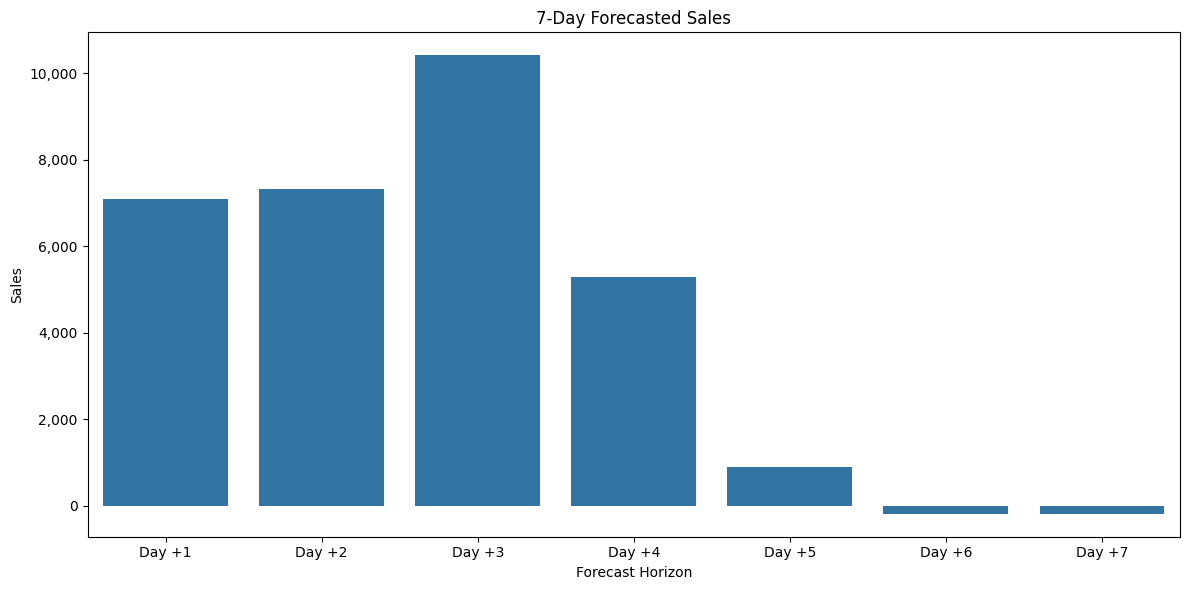

In [57]:
sequence_length = 30
forecast_horizon = 7
forecast_sequence = df[features].iloc[-sequence_length:].copy().values.tolist()  
forecasted_sales_scaled = []

for i in range(forecast_horizon):
    input_seq = np.array(forecast_sequence[-sequence_length:]).reshape(1, sequence_length, len(features))

    pred_scaled = new_model.predict(input_seq, verbose=0)
    forecasted_sales_scaled.append(pred_scaled[0][0])

    next_row = forecast_sequence[-1].copy()

    next_row[features.index("DayOfWeek")] = (next_row[features.index("DayOfWeek")] + 1) % 7
    next_row[features.index("IsWeekend")] = 1 if next_row[features.index("DayOfWeek")] >= 5 else 0


    forecast_sequence.append(next_row)  

forecasted_sales = target_scaler.inverse_transform(np.array(forecasted_sales_scaled).reshape(-1, 1))

forecast_df = pd.DataFrame({
    "Day": [f"Day +{i+1}" for i in range(forecast_horizon)],
    "Forecasted Sales": forecasted_sales.flatten()
})

plt.figure(figsize=(12, 6))
sns.barplot(x="Day", y="Forecasted Sales", data=forecast_df)
plt.title("7-Day Forecasted Sales")
plt.ylabel("Sales")
plt.xlabel("Forecast Horizon")
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{int(x):,}'))
plt.tight_layout()
plt.show()


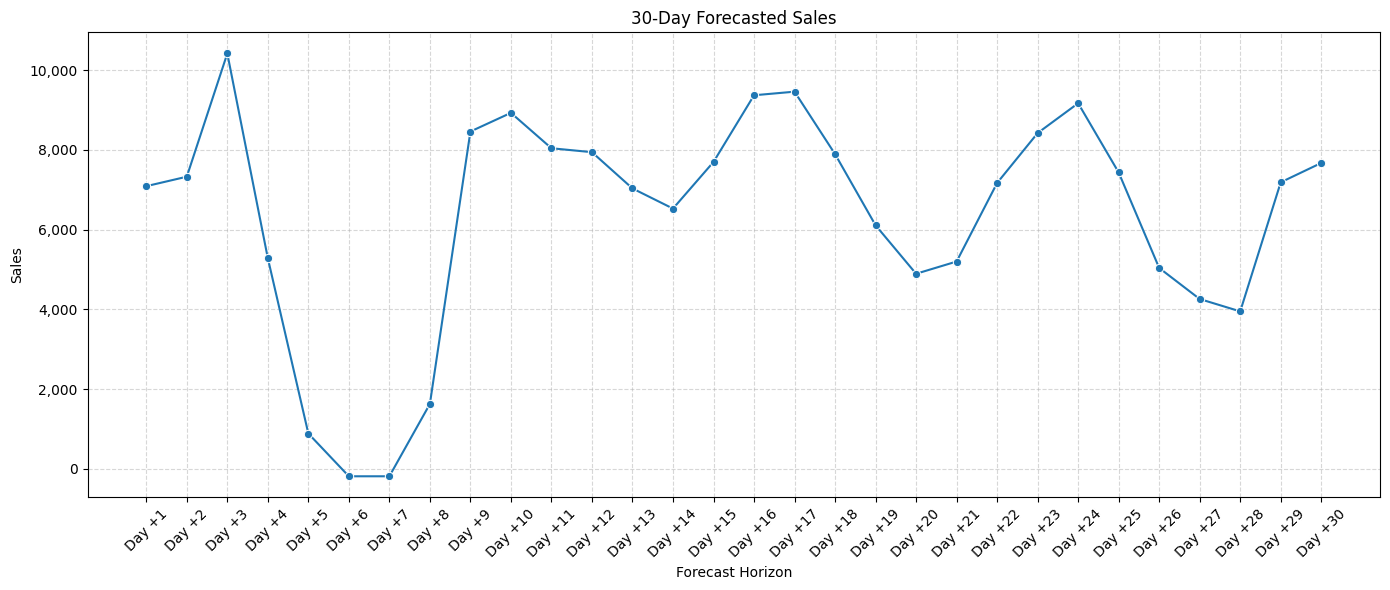

In [58]:
sequence_length = 30
forecast_horizon = 30

forecast_sequence = df[features].iloc[-sequence_length:].copy().values.tolist()

forecasted_sales_scaled = []

for i in range(forecast_horizon):
    input_seq = np.array(forecast_sequence[-sequence_length:]).reshape(1, sequence_length, len(features))

    pred_scaled = new_model.predict(input_seq, verbose=0)
    forecasted_sales_scaled.append(pred_scaled[0][0])

    next_row = forecast_sequence[-1].copy()
    next_row[features.index("DayOfWeek")] = (next_row[features.index("DayOfWeek")] + 1) % 7
    next_row[features.index("IsWeekend")] = 1 if next_row[features.index("DayOfWeek")] >= 5 else 0

    forecast_sequence.append(next_row)

forecasted_sales = target_scaler.inverse_transform(np.array(forecasted_sales_scaled).reshape(-1, 1))

forecast_df_30 = pd.DataFrame({
    "Day": [f"Day +{i+1}" for i in range(forecast_horizon)],
    "Forecasted Sales": forecasted_sales.flatten()
})

plt.figure(figsize=(14, 6))
sns.lineplot(data=forecast_df_30, x="Day", y="Forecasted Sales", marker="o")
plt.title("30-Day Forecasted Sales")
plt.ylabel("Sales")
plt.xlabel("Forecast Horizon")
plt.xticks(rotation=45)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{int(x):,}'))
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()
